# Machine learning for clustering
**1. EM from scratch with the help of the ML lesson slides.**                                 

**2. EM with scikit-learn**

**3. kMeans with scikit-learn**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import mixture

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Visualisation de l'image

([], [])

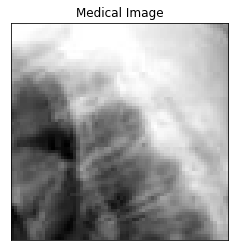

In [ ]:
tab=pd.read_table('/content/drive/MyDrive/irm_thorax.txt',sep=';',header=None) 
plt.imshow(tab, cmap='gray');
plt.title('Medical Image')
plt.xticks([], []); plt.yticks([], []) 

Histogram of Data

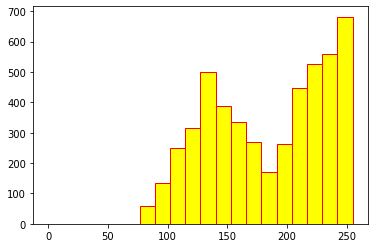

In [ ]:
t = np.array(tab)
n=len(t); 
X=t.reshape(n*n);
plt.hist(X, range = (0, 255), bins = 20, color = 'yellow', edgecolor = 'red');

# My own python instructions to implement the EM algorithm from scratch with the help of the ML lesson slides.

In [ ]:
from random import sample
import statistics

### Initialization step of parameters

In [ ]:
K = 2

# def varEstim(X):
#     emp = np.mean(X)
#     soust = (X - emp)**2
#     res = np.mean(soust)
#     return res

def initParameters(X, K=2):
    pi = np.repeat(1/K,K)
    random_row = np.random.randint(low=0, high=len(X), size=K)
    mu = [X[row_index] for row_index in random_row ]
    sigma = np.array([statistics.stdev(X), statistics.stdev(X)])
    parameters = {
        'pi': pi,
        'mu': mu,
        'sigma': sigma
        #'lambdas': lambdas
    }
    return parameters   

In [ ]:
initParams = initParameters(X, K=2)
print(initParams)

{'pi': array([0.5, 0.5]), 'mu': [105, 136], 'sigma': array([49.71921158, 49.71921158])}


In [ ]:
from scipy.stats import norm
from scipy.stats import poisson

### E step

In [ ]:
def applyF(mat):
    somme = np.sum(mat, axis = 1)
    for i in range(len(mat)):
        if (somme[i] == 0):
            mat[i,:] = 0
        else:
            mat[i,:] = mat[i,:]/somme[i]
    return mat
    
def etape_E(X, K, parameters):
    T = np.zeros((X.shape[0], K))
    tmp = np.zeros((X.shape[0], K))
    for k in range(K):
        T[:,k] = parameters["pi"][k]*norm.pdf(X, parameters["mu"][k], np.sqrt(parameters["sigma"][k]))
    tmp = applyF(T)
    return tmp

In [ ]:
#E = etape_E(X, K, parameters)
#print(E)

### M step

In [ ]:
def etape_M(E, X, K):
    mu = np.zeros(K)
    sigma = np.zeros(K)
    lambdas = np.zeros(K)
    pi = np.zeros(K)
    for k in range(K):
        Nk = np.sum(E[:,k])
        mu[k] = np.sum(E[:,k]*X)/Nk
        diff = (X-mu[k]).T
        weighted_sum = np.dot(E[:,k] * diff, diff.T)
        sigma[k] = weighted_sum/Nk
        pi[k] = Nk/len(X)
    parameters = {
        'pi': pi,
        'mu': mu,
        'sigma': sigma
    }
    return parameters   

In [ ]:
#etape_M(E, X, K)

Algorithm EM with initialization of parameters, E and M steps

In [ ]:
def transformDictInArr(obj):
    tab = np.zeros(len(obj)*2)
    i = 0
    for a in obj:
        tab[i] = obj[a][0]
        tab[i+1] = obj[a][1]
        i = i + 2
    return tab        
    
    
def EM(X, K):
    parameters = initParameters(X, K=2)
    lambdas = np.repeat(1, K)
    oldParameters = {
        'pi': [0.5, 0.5],
        'mu': [12,30],
        'sigma': [1,6],
    }
    T = np.zeros((len(X), K))
    
    while(np.mean((transformDictInArr(parameters) - transformDictInArr(oldParameters))**2)>1e-16):
        oldParameters = parameters
        T = etape_E(X, K, parameters)
        parameters = etape_M(T, X, K)
        #print(parameters)
    
    results = {
        'T': T,
        'parameters': parameters 
    }
    return results

In [ ]:
import math

In [ ]:
def densGauss(x, mu, sigma):
    num = np.exp(-((x-mu)**2)/(2*sigma))
    denom = np.sqrt(2*math.pi)*np.sqrt(sigma)
    fx = num/denom
    return fx

### Test

Paramètres  pi [0.50364907 0.49635093]
Paramètres  mu [141.056503   228.71466739]
Paramètres  sigma [764.05751066 335.96835955]


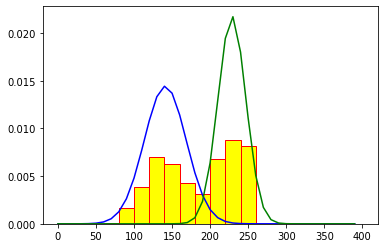

In [ ]:

EM_ = EM(X, K)


def showParameters(result):
    parameters = result['parameters']
    for parameter in parameters:
        print("Paramètres ", parameter, parameters[parameter])
    

mu0 = EM_['parameters']['mu'][0]
sigma0 = EM_['parameters']['sigma'][0]

mu1 = EM_['parameters']['mu'][1]
sigma1 = EM_['parameters']['sigma'][1]

showParameters(EM_)

arr = np.arange(0, 400, 10)
plt.hist(X, range = (0,400), bins = 20, color = 'yellow', density=True, edgecolor = 'red');

plt.plot(arr, norm.pdf(arr, mu0, np.sqrt(sigma0)), color = 'blue')
plt.plot(arr, norm.pdf(arr, mu1, np.sqrt(sigma1)), color = 'green')
plt.show()

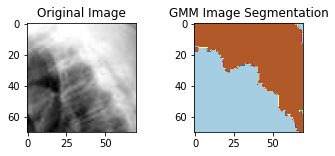

In [ ]:
def predict_proba(X, K, pi, mu, sigma):
    tab = np.zeros((len(X),K))
    for k in range(K):
        tab[:,k] = pi[k]*norm.pdf(X, mu[k], np.sqrt(sigma[k]))
    return tab


predictions_proba = predict_proba(X, K,EM_['parameters']['pi'], EM_['parameters']['mu'], EM_['parameters']['sigma'])

predictions = np.argmax(predictions_proba, axis=1)
imgGMMK2 = predictions.reshape(n,n);

figure = plt.figure(figsize=(5.5,2));
plt.xticks([], []); plt.yticks([], []);
ax = plt.subplot(1,2, 1); ax.imshow(tab, cmap='gray');
ax.set_title('Original Image')
ax = plt.subplot(1,2, 2); ax.imshow(imgGMMK2, cmap='Paired')
ax.set_title('GMM Image Segmentation')
plt.show();

# With scikit-learn

## K = 2

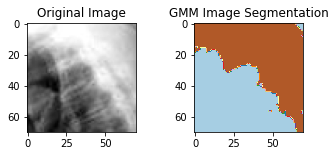

In [ ]:
from sklearn import mixture
X2 = X.reshape(-1, 1)
modgmm = mixture.GaussianMixture(n_components=2, covariance_type='full');
fitgmm=modgmm.fit(X2);
predX=fitgmm.fit_predict(X2);
imgGMMK2=predX.reshape(n,n);
figure = plt.figure(figsize=(5.5,2));
plt.xticks([], []); plt.yticks([], []);
ax = plt.subplot(1,2, 1); ax.imshow(tab, cmap='gray');
ax.set_title('Original Image')
ax = plt.subplot(1,2, 2); ax.imshow(imgGMMK2, cmap='Paired')
ax.set_title('GMM Image Segmentation')
plt.show();

In [ ]:
print('Weights', modgmm.weights_)
print('Means', modgmm.means_)
print('Covariances', modgmm.covariances_)

Weights [0.48837536 0.51162464]
Means [[139.41896295]
 [227.66090423]]
Covariances [[[693.66739881]]

 [[367.61971236]]]


## K = 3

(4900, 1)


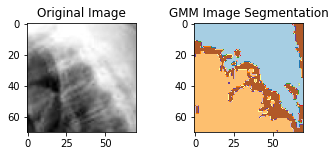

In [ ]:
from sklearn import mixture
X2 = X.reshape(-1, 1)
print(X2.shape)
modgmm = mixture.GaussianMixture(n_components=3, covariance_type='full');
fitgmm=modgmm.fit(X2);
predX=fitgmm.fit_predict(X2);
imgGMMK3=predX.reshape(n,n);

figure = plt.figure(figsize=(5.5,2));
plt.xticks([], []); plt.yticks([], []);
ax = plt.subplot(1,2, 1); ax.imshow(tab, cmap='gray');
ax.set_title('Original Image')
ax = plt.subplot(1,2, 2); ax.imshow(imgGMMK3, cmap='Paired')
ax.set_title('GMM Image Segmentation')
plt.show();

In [ ]:
print('Weights', modgmm.weights_)
print('Means', modgmm.means_)
print('Covariances', modgmm.covariances_)

Weights [0.41198685 0.37783362 0.21017953]
Means [[233.30172561]
 [130.79355994]
 [185.69965931]]
Covariances [[[239.91814456]]

 [[477.69284694]]

 [[579.61762919]]]


## K = 5

[[254]
 [255]
 [254]
 ...
 [195]
 [200]
 [199]]


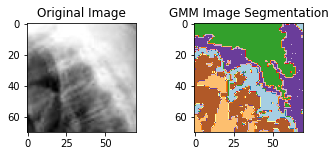

In [ ]:
from sklearn import mixture
X2 = X.reshape(-1, 1)
print(X2)
modgmm = mixture.GaussianMixture(n_components=5, covariance_type='full');
fitgmm=modgmm.fit(X2);
predX=fitgmm.fit_predict(X2);
imgGMMK5=predX.reshape(n,n);

figure = plt.figure(figsize=(5.5,2));
plt.xticks([], []); plt.yticks([], []);
ax = plt.subplot(1,2, 1); ax.imshow(tab, cmap='gray');
ax.set_title('Original Image')
ax = plt.subplot(1,2, 2); ax.imshow(imgGMMK5, cmap='Paired')
ax.set_title('GMM Image Segmentation')
plt.show();

In [ ]:
print('Weights', modgmm.weights_)
print('Means', modgmm.means_)
print('Covariances', modgmm.covariances_)

Weights [0.14602304 0.26375208 0.11427024 0.24688241 0.22907223]
Means [[168.42249408]
 [242.34179116]
 [105.58218349]
 [212.8021437 ]
 [137.30163086]]
Covariances [[[161.0407033 ]]

 [[ 95.97289463]]

 [[154.95019613]]

 [[153.99214509]]

 [[122.25569669]]]


# K means

[[124.8031348 ]
 [232.18112014]
 [175.30889093]]


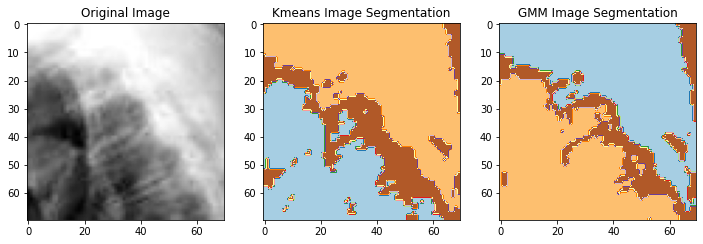

In [ ]:
from sklearn.cluster import KMeans
X2 = X.reshape(-1, 1)
modkmeans = KMeans(n_clusters=3, random_state=0)
fitkmeans=modkmeans.fit(X2)
predX=fitkmeans.fit_predict(X2);
imgKmeans=predX.reshape(n,n);

print(modkmeans.cluster_centers_)

figure = plt.figure(figsize=(12,6));
plt.xticks([], []); plt.yticks([], []);
ax = plt.subplot(1,3, 1); ax.imshow(tab, cmap='gray');
ax.set_title('Original Image')
ax = plt.subplot(1,3, 2); ax.imshow(imgKmeans, cmap='Paired')
ax.set_title('Kmeans Image Segmentation')
ax = plt.subplot(1,3, 3); ax.imshow(imgGMMK3, cmap='Paired')
ax.set_title('GMM Image Segmentation')
plt.show();